# Final Year Deep Learning Project
### "Developing a CNN model using Transfer Learning to predict Age, Gender and Race"

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [1]:
# downloading the data from kaggle server to colab server
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 98% 326M/331M [00:01<00:00, 354MB/s]
100% 331M/331M [00:01<00:00, 329MB/s]


In [2]:
# unzipping the data
import zipfile
zip = zipfile.ZipFile("/content/utkface-new.zip",'r')
zip.extractall("/content")
zip.close()

## Importing all necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model, load_model
from keras.applications.vgg16 import VGG16
from keras.layers import *
from keras.models import Model
from keras.utils import to_categorical

## Creating the dataframe from downloaded data

In [4]:
path = '/content/utkface_aligned_cropped/UTKFace'
age = []
gender = []
race = []
img_path=[]
for file in os.listdir(path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  race.append((file.split('_')[2]))
  img_path.append(file)

In [5]:
df = pd.DataFrame({'age':age,'gender':gender,'race':race,'img_path':img_path})

In [6]:
df.head()

,age,gender,race,img_path
0,24,1,2,24_1_2_20170116161819263.jpg.chip.jpg
1,1,1,3,1_1_3_20161220142900393.jpg.chip.jpg
2,22,1,4,22_1_4_20170103224424415.jpg.chip.jpg
3,59,0,2,59_0_2_20170113190433215.jpg.chip.jpg
4,19,1,2,19_1_2_20170104021632526.jpg.chip.jpg


In [7]:
df['race'].value_counts()

,count
race,
0,10078
1,4526
3,3975
2,3434
4,1692
20170116174525125.jpg.chip.jpg,1
20170109142408075.jpg.chip.jpg,1
20170109150557335.jpg.chip.jpg,1


## Removing the 3 images whose "race" is not present

In [8]:
# first, we split the 'img_path' by the underscore and keep only rows where race exists
df['split_values'] = df['img_path'].str.split('_')

# now, filter rows where the length of the split values is at least 4 (to ensure age, gender, and race are present)
df_filtered = df[df['split_values'].apply(len) >= 4]

# drop the column 'split_values'
df = df_filtered.drop(columns=['split_values'])

# display the filtered dataframe
df.head()

,age,gender,race,img_path
0,24,1,2,24_1_2_20170116161819263.jpg.chip.jpg
1,1,1,3,1_1_3_20161220142900393.jpg.chip.jpg
2,22,1,4,22_1_4_20170103224424415.jpg.chip.jpg
3,59,0,2,59_0_2_20170113190433215.jpg.chip.jpg
4,19,1,2,19_1_2_20170104021632526.jpg.chip.jpg


In [9]:
df['race'].value_counts()

,count
race,
0,10078
1,4526
3,3975
2,3434
4,1692


In [10]:
df['gender'] = df['gender'].astype('int32')
df['age'] = df['age'].astype('int32')
df['race'] = df['race'].astype('int32')
df.dtypes

,0
age,int32
gender,int32
race,int32
img_path,object


## Checking any image from the dataframe

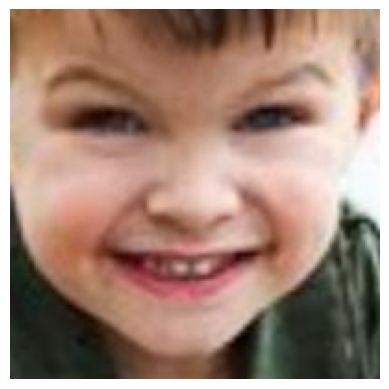

In [11]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("/content/utkface_aligned_cropped/UTKFace/" + df['img_path'][1672])

# Display the image using plt.imshow
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()

In [2]:
# constructing dictionary for gender and race
gender_dict = {0:"Male",1:"Female"}
race_dict = {0:"White",1:"Black",2:"Asian",3:"Indian",4:"Others"}

In [13]:
# making a copy of df and cnverting numerical columns to categorical for EDA
data = df.copy()
data['race'] = data['race'].map(race_dict)
data['gender'] = data['gender'].map(gender_dict)
data.head()

,age,gender,race,img_path
0,24,Female,Asian,24_1_2_20170116161819263.jpg.chip.jpg
1,1,Female,Indian,1_1_3_20161220142900393.jpg.chip.jpg
2,22,Female,Others,22_1_4_20170103224424415.jpg.chip.jpg
3,59,Male,Asian,59_0_2_20170113190433215.jpg.chip.jpg
4,19,Female,Asian,19_1_2_20170104021632526.jpg.chip.jpg


## Visualising the distribution of age

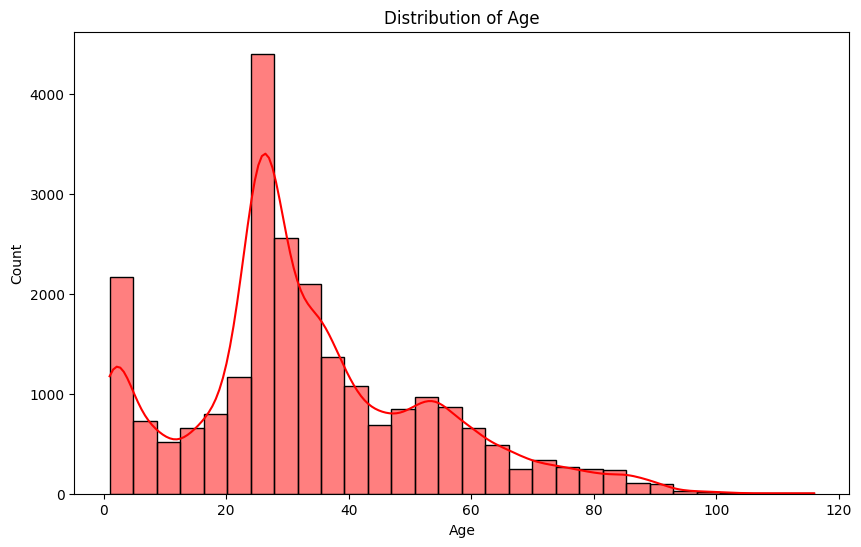

In [14]:
plt.figure(figsize=(10,6))
sns.histplot(data['age'],bins=30,color='red', edgecolor='black', kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

## Visualising the distribution of gender

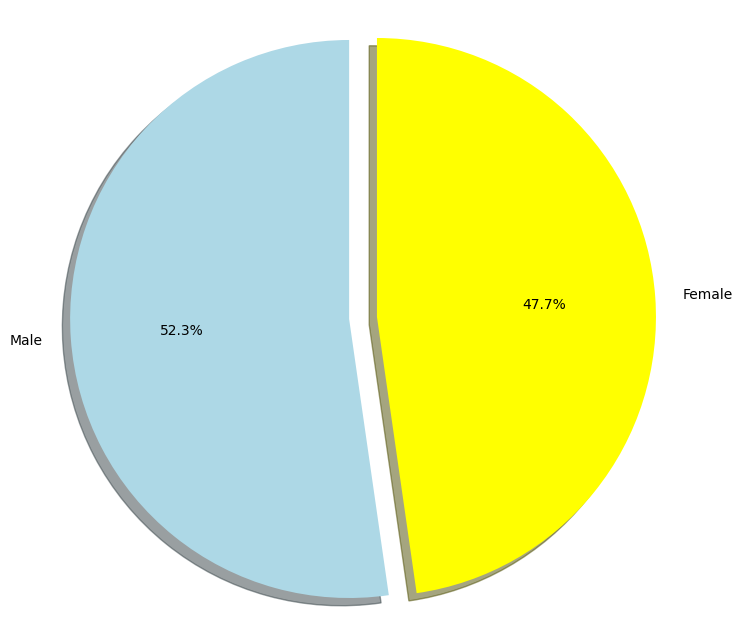

In [15]:
# Count the occurrences of each gender
gender_counts = data['gender'].value_counts()

# Extract the labels directly from the unique values in the 'gender' column
labels = gender_counts.index

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'yellow'], explode=[0, 0.1], shadow=True)

# Equal aspect ratio ensures the pie is drawn as a circle.
plt.axis('equal')

# Display the chart
plt.show()

## Visualising the distribution of race

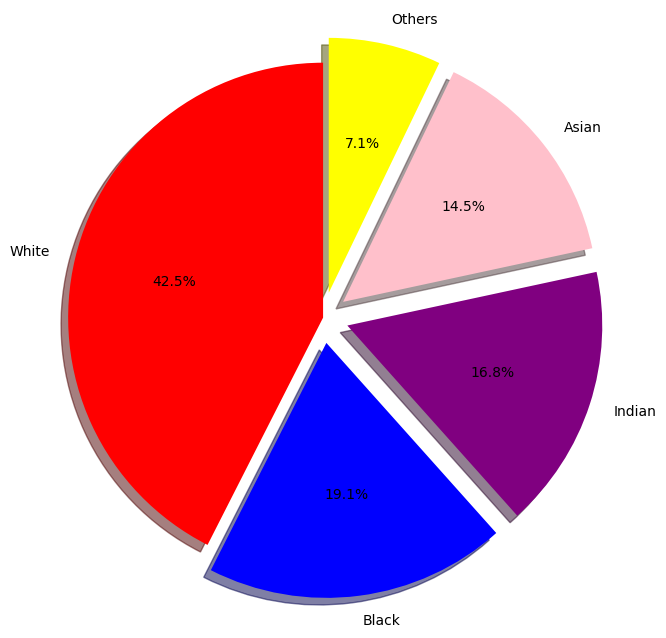

In [16]:
# Count the occurrences of each race
race_counts = data['race'].value_counts()

# Extract the labels directly from the unique values in the 'race' column
labels = race_counts.index

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(race_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['red','blue','purple','pink','yellow'],explode = [0] + [0.1] * 4, shadow=True)

# Equal aspect ratio ensures the pie is drawn as a circle.
plt.axis('equal')

# Display the chart
plt.show()

## Splitting the data into training and testing set

In [17]:
train, test = train_test_split(df, train_size=0.8, random_state=42)

In [18]:
train.shape

(18964, 4)

In [19]:
test.shape

(4741, 4)

In [20]:
train.head()

,age,gender,race,img_path
21097,1,0,0,1_0_0_20170110213403723.jpg.chip.jpg
20880,24,1,2,24_1_2_20170116173449887.jpg.chip.jpg
21547,32,1,1,32_1_1_20170116234627342.jpg.chip.jpg
13629,26,0,1,26_0_1_20170113151630983.jpg.chip.jpg
8226,23,1,0,23_1_0_20170117144809468.jpg.chip.jpg


In [21]:
test.head()

,age,gender,race,img_path
17815,27,0,3,27_0_3_20170119193230738.jpg.chip.jpg
15081,32,1,0,32_1_0_20170103163347255.jpg.chip.jpg
22832,2,0,3,2_0_3_20161220143322854.jpg.chip.jpg
16075,64,0,0,64_0_0_20170117194627251.jpg.chip.jpg
8973,18,1,0,18_1_0_20170109212425897.jpg.chip.jpg


## Normalisation and data augmentation(data preprocessing)


In [22]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [23]:
train_data = train_datagen.flow_from_dataframe(train,
                                                    directory = path,
                                                    x_col='img_path',
                                                    y_col=['age','gender','race'],
                                                    target_size=(150,150),
                                                    class_mode='multi_output')

test_data = test_datagen.flow_from_dataframe(test,
                                                    directory= path,
                                                    x_col='img_path',
                                                    y_col=['age','gender','race'],
                                                    target_size=(150,150),
                                                  class_mode='multi_output')

Found 18964 validated image filenames.
Found 4741 validated image filenames.


## Loading the pretrained model 'VGG16'

In [3]:
# storing the convolution layers from VGG16 model
vgg = VGG16(
    weights='imagenet',
    include_top = False, # not including the fully connected layers
    input_shape=(150,150,3) # image is of size (256*256) with 3 filters
)

In [4]:
# fine tuning the convolution layer(freezing first 4 blocks and keeping 5th block trainable)
vgg.trainable = True  # initially set all the layers of vgg16 as trainable

temp = False  # a temporary variable

# running a for loop to freeze first 4 layers
for layer in vgg.layers:
  if layer.name == 'block5_conv1':
    temp = True
  if temp:
    layer.trainable = True
  else:
    layer.trainable = False

# printing the name of layers and trainable condition
for layer in vgg.layers:
  print(layer.name,'->',layer.trainable)

input_layer -> False
block1_conv1 -> False
block1_conv2 -> False
block1_pool -> False
block2_conv1 -> False
block2_conv2 -> False
block2_pool -> False
block3_conv1 -> False
block3_conv2 -> False
block3_conv3 -> False
block3_pool -> False
block4_conv1 -> False
block4_conv2 -> False
block4_conv3 -> False
block4_pool -> False
block5_conv1 -> True
block5_conv2 -> True
block5_conv3 -> True
block5_pool -> True


In [5]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

## Model architecture building

In [7]:
# Input layer for the model
vgg_input = Input(shape=(150, 150, 3))

x = vgg(vgg_input)
flatten = Flatten()(x)

# Dense layers for age, gender, and race prediction
dense1_1 = Dense(64, activation='relu')(flatten)
dense1_2 = Dense(64,activation='relu')(flatten)
dense1_3 = Dense(64,activation='relu')(flatten)

dense2_1 = Dense(16,activation='relu')(dense1_1)
dense2_2 = Dense(16,activation='relu')(dense1_2)
dense2_3 = Dense(16,activation='relu')(dense1_3)

output1 = Dense(1,activation='linear',name='age')(dense2_1)
output2 = Dense(1,activation='sigmoid',name='gender')(dense2_2)
output3 = Dense(5,activation='softmax',name='race')(dense2_3)


In [8]:
model = Model(inputs=vgg_input,outputs=[output1,output2,output3])

In [9]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 4, 4, 512) │ 14,714,688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8192)      │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │    524,352 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │    524,352 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │    524,352 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │      1,040 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16)        │      1,040 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 16)        │      1,040 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age (Dense)         │ (None, 1)         │         17 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender (Dense)      │ (None, 1)         │         17 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ race (Dense)        │ (None, 5)         │         85 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,290,983 (62.15 MB)

 Trainable params: 8,655,719 (33.02 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

## Visualising the model architecture

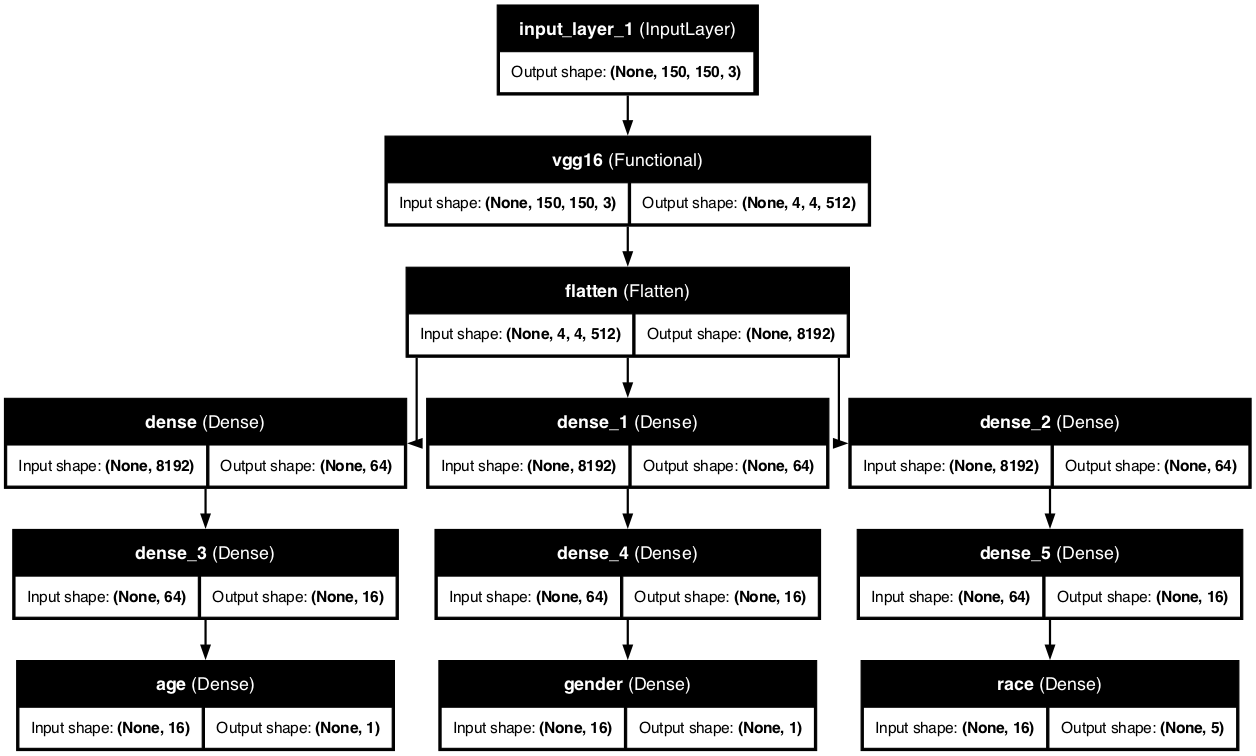

In [10]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, dpi = 80)

## Compiling and training the model

In [31]:
model.compile(
    optimizer='adam',
    loss={
        'age': 'mae',
        'gender': 'binary_crossentropy',
        'race': 'sparse_categorical_crossentropy'
    },
    metrics={
        'age': 'mae',
        'gender': 'accuracy',
        'race': 'accuracy'
    },
    loss_weights={
        'age': 2,
        'gender': 10,
        'race': 5
    }
)

In [32]:
history = model.fit(train_data, batch_size=32, epochs=10, validation_data=test_data)

Epoch 1/10
593/593 [==============================] - 299s 499ms/step - loss: 31.8453 - age_loss: 9.7030 - gender_loss: 0.5581 - race_loss: 1.3716 - age_mae: 9.7030 - gender_accuracy: 0.7033 - race_accuracy: 0.4490 - val_loss: 25.7721 - val_age_loss: 8.1955 - val_gender_loss: 0.3556 - val_race_loss: 1.1650 - val_age_mae: 8.1955 - val_gender_accuracy: 0.8304 - val_race_accuracy: 0.5421
Epoch 2/10
593/593 [==============================] - 294s 495ms/step - loss: 25.5437 - age_loss: 8.1129 - gender_loss: 0.3746 - race_loss: 1.1145 - age_mae: 8.1129 - gender_accuracy: 0.8267 - race_accuracy: 0.5741 - val_loss: 22.2005 - val_age_loss: 7.2544 - val_gender_loss: 0.2984 - val_race_loss: 0.9416 - val_age_mae: 7.2544 - val_gender_accuracy: 0.8585 - val_race_accuracy: 0.6456
Epoch 3/10
593/593 [==============================] - 296s 498ms/step - loss: 23.6881 - age_loss: 7.6894 - gender_loss: 0.3306 - race_loss: 1.0007 - age_mae: 7.6894 - gender_accuracy: 0.8503 - race_accuracy: 0.6294 - val_los

## Save the model's weights to a HDF5 file to avoid retraining the model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

model.save_weights('/content/drive/MyDrive/DeepLearningModels/model_weights.h5')

In [11]:
# loading the weights of saved model(already downloaded the model to my local drive)
model.load_weights('//Users/himanshukumarsingh/Downloads/model_weights.h5')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 4, 4, 512) │ 14,714,688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8192)      │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │    524,352 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │    524,352 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │    524,352 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │      1,040 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16)        │      1,040 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 16)        │      1,040 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age (Dense)         │ (None, 1)         │         17 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender (Dense)      │ (None, 1)         │         17 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ race (Dense)        │ (None, 5)         │         85 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,290,983 (62.15 MB)

 Trainable params: 8,655,719 (33.02 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

## Visualising the loss and accuracy of model on all the output variables


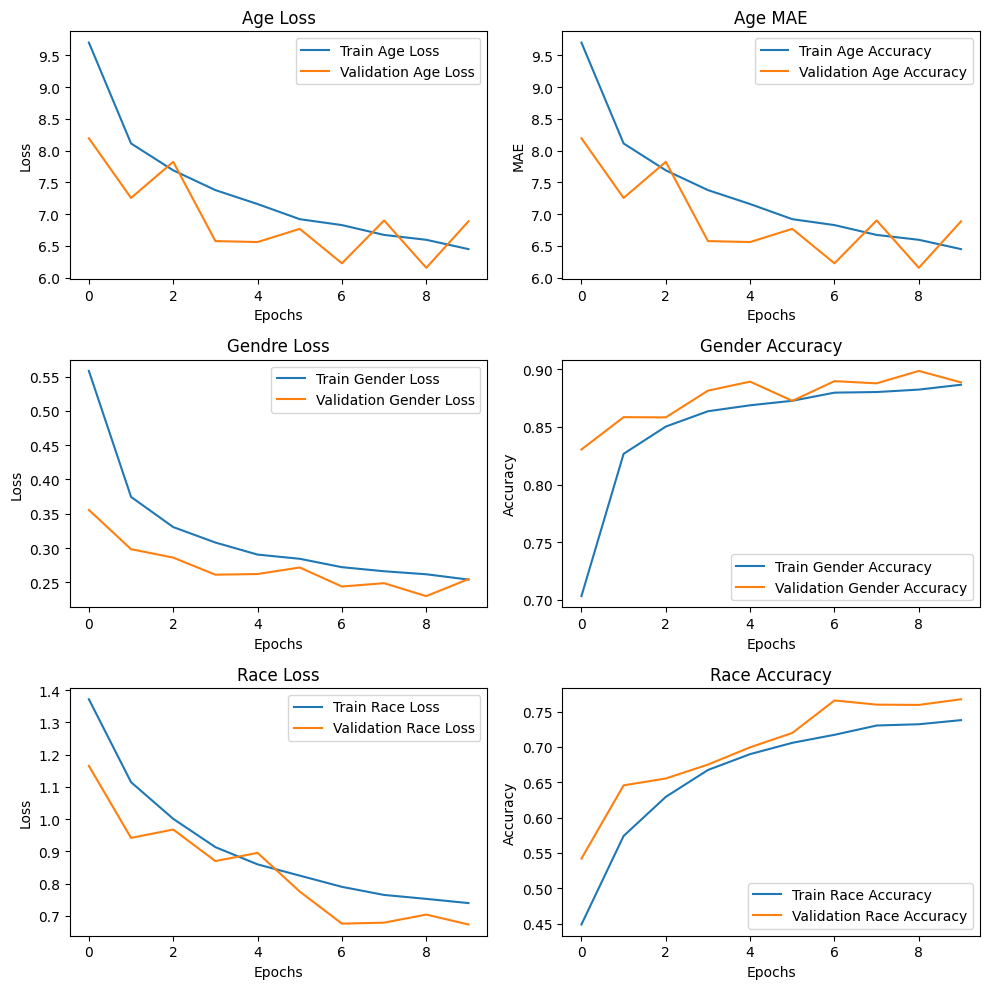

In [33]:
plt.figure(figsize = (10,10))

# Extract loss for each output
age_train_loss = history.history['age_loss']
age_val_loss = history.history['val_age_loss']

gender_train_loss = history.history['gender_loss']
gender_val_loss = history.history['val_gender_loss']

race_train_loss = history.history['race_loss']
race_val_loss = history.history['val_race_loss']

# Extract accuracy for each output
age_train_acc = history.history['age_mae']
age_val_acc = history.history['val_age_mae']

gender_train_acc = history.history['gender_accuracy']
gender_val_acc = history.history['val_gender_accuracy']

race_train_acc = history.history['race_accuracy']
race_val_acc = history.history['val_race_accuracy']

# plotting the loss and accuracy of Age
plt.subplot(3,2,1)
plt.plot(age_train_loss, label='Train Age Loss')
plt.plot(age_val_loss, label='Validation Age Loss')
plt.title('Age Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3,2,2)
plt.plot(age_train_acc, label='Train Age Accuracy')
plt.plot(age_val_acc, label='Validation Age Accuracy')
plt.title('Age MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# plotting the loss and accuracy of Gender
plt.subplot(3,2,3)
plt.plot(gender_train_loss, label='Train Gender Loss')
plt.plot(gender_val_loss, label='Validation Gender Loss')
plt.title('Gendre Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3,2,4)
plt.plot(gender_train_acc, label='Train Gender Accuracy')
plt.plot(gender_val_acc, label='Validation Gender Accuracy')
plt.title('Gender Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# plotting the loss and accuracy of Race
plt.subplot(3,2,5)
plt.plot(race_train_loss, label='Train Race Loss')
plt.plot(race_val_loss, label='Validation Race Loss')
plt.title('Race Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3,2,6)
plt.plot(race_train_acc, label='Train Race Accuracy')
plt.plot(race_val_acc, label='Validation Race Accuracy')
plt.title('Race Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [38]:
# Use the model for predictions or further training
predictions = model.predict(test_data)

149/149 [==============================] - 39s 261ms/step


## Function to make prediction on any custom image


In [17]:
# constructing dictionary for gender and race
gender_dict = {0:"Male",1:"Female"}
race_dict = {0:"White",1:"Black",2:"Asian",3:"Indian",4:"Others"}

def predict(image_path):

  # Load and preprocess the image
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
  img = cv2.resize(img, (150, 150))  # Resize to the input shape of your model
  img = img / 255.0  # Normalize to [0, 1]
  img = np.expand_dims(img, axis=0)  # Add batch dimension

  # Make predictions
  prediction = model.predict(img)

  # Post-process predictions
  predicted_age = prediction[0][0][0] # Assuming age is the first output
  predicted_gender_prob = prediction[1][0][0]  # Assuming gender is the second output
  predicted_race_prob = prediction[2][0]  # Assuming race probabilities start from the third output

  # Gender prediction
  predicted_gender = "Female" if predicted_gender_prob >= 0.5 else "Male"

  # Race prediction (assuming race is multi-class)
  predicted_race_label = np.argmax(predicted_race_prob)  # Get the predicted race label
  predicted_race = race_dict[predicted_race_label]  # Convert probabilities to class label

  # Display results
  print(f"Predicted Age: {predicted_age:.2f}")
  print(f"Predicted Gender: {predicted_gender}")
  print(f"Predicted Race: {predicted_race}")  # You'll want to map this to actual race labels

  # display the image
  plt.imshow(img[0])
  plt.axis('off')
  plt.show()


## Making predictions on custom images


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Predicted Age: 33.47
Predicted Gender: Male
Predicted Race: White


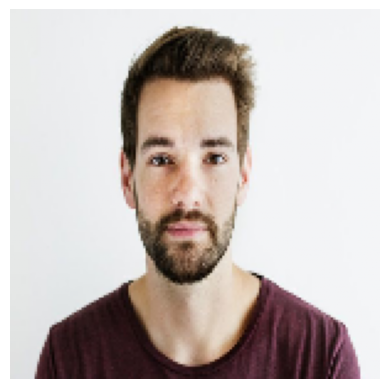

In [18]:
predict('/Users/himanshukumarsingh/Downloads/c8ff88ba5d7c2844bfbeaaa0837d1de5.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Predicted Age: 42.09
Predicted Gender: Male
Predicted Race: Black


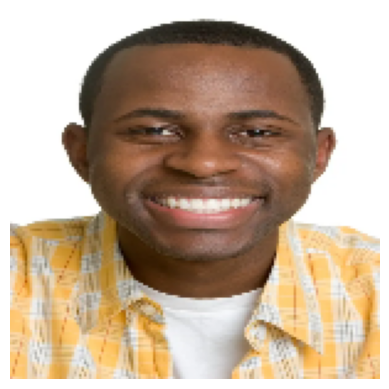

In [19]:
predict('/Users/himanshukumarsingh/Downloads/smiling-black-man-4725389.jpg.webp')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Predicted Age: 40.25
Predicted Gender: Female
Predicted Race: White


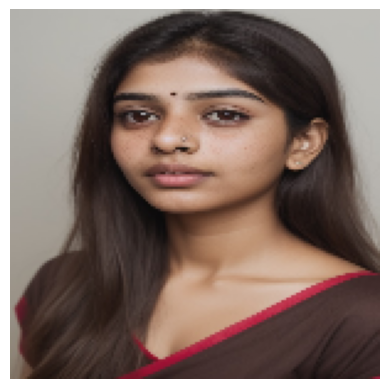

In [33]:
predict('/Users/himanshukumarsingh/Downloads/indian.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Predicted Age: 47.07
Predicted Gender: Female
Predicted Race: Black


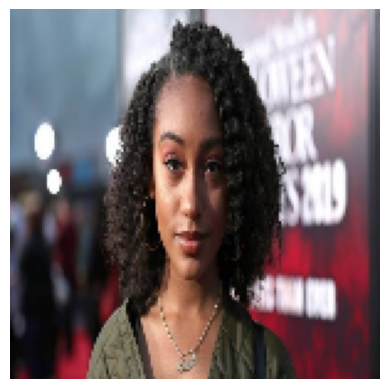

In [15]:
predict('/Users/himanshukumarsingh/Downloads/1233.jpg')

## Using openCV to access camera and make predictions on realtime videos(picture frames)


In [19]:
# Function to make prediction on a frame
def predict(frame):

  # Load and preprocess the image
  img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
  img_resized = cv2.resize(img, (150, 150))  # Resize to the input shape of your model
  img_normalized = img_resized / 255.0  # Normalize to [0, 1]
  img_expanded = np.expand_dims(img_normalized, axis=0)  # Add batch dimension

  # Make predictions
  prediction = model.predict(img_expanded)

  # Post-process predictions
  predicted_age = prediction[0][0][0]  # Assuming age is the first output
  predicted_gender_prob = prediction[1][0][0]  # Assuming gender is the second output
  predicted_race_prob = prediction[2][0]  # Assuming race probabilities start from the third output

  # Gender prediction
  predicted_gender = "Female" if predicted_gender_prob >= 0.5 else "Male"

  # Race prediction
  predicted_race_label = np.argmax(predicted_race_prob)  # Get the predicted race label
  predicted_race = race_dict[predicted_race_label]  # Convert probabilities to class label

  return predicted_age, predicted_gender, predicted_race

# Function to start video capture
def start_video_capture():
  # Start capturing video
  cap = cv2.VideoCapture(0)  # 0 for the default camera

  while True:
    ret, frame = cap.read()
    if not ret:
      print('Error: Failed to capture image from camera.\nCamera out of service.')
      break

    # Make predictions
    age, gender, race = predict(frame)

    # Draw rectangle and put text on the frame
    cv2.putText(frame, f"Age: {age:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Gender: {gender}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Race: {race}", (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Display the resulting frame
    cv2.imshow('Video Feed', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
      break

  # Release the capture and close windows
  cap.release()
  cv2.destroyAllWindows()


In [25]:
# Start the video capture
start_video_capture()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━